# PyProdrisk: Basic example

In this example, we build a simple Prodrisk model containing one module, add dummy price and inflow data, and run a simulation over three years.

Here, all input is directly given through the API without any input file parsing.

While the model in this example is quite simple, it can serve as a good reference when designing your own models. It illustrates an intuitive way of designing models using pyProdrisk by incrementally initializing new objects like modules, inflowSeries, area and setting, and setting their key attributes. The model is then optimized, before the results are retrieved and presented through plots.

## Imports and settings

The first thing we do is to import the needed packages. You can import whichever packages you like, however we use the following ones for this example:

- pandas and numpy to structure our data
- pyprodrisk in order to create a Prodrisk session

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyprodrisk import ProdriskSession

## Building the model

In this example we define the entire topology and generate all its parameters via Python and the API. Below are simple examples on how to define the most common topology objects needed in order to run Prodrisk.

### Instancing Prodrisk

In order to have Prodrisk receive our inputs, run the model we create and give us results, we need to create an active, running Prodrisk session.

You may create multiple Prodrisk sessions simultaneously if needed.

In [2]:
# --- create a new session ---

prodrisk = ProdriskSession(license_path='/prodrisk', solver_path='/pyprodrisk', silent=False, log_file='')

### Setting time resolutions and settings for the model

We set the time resolution for the model ourselves, as we generate all input as we go.

The time resolution is set by the price_periods time series (only input data from the first 168 hours is used). This input group the hours during the week into blocks with identical price, which not necessarily have to be sequential. This example use daily time resolution. Prodrisk may be run with hourly resolution, but for most cases this will lead to a long computation time.

In [3]:
# --- configure settings for the session ---

prodrisk.set_optimization_period(
    pd.Timestamp("2021-01-04"),
    n_weeks = 156
)

prodrisk.n_scenarios = 10
prodrisk.use_coin_osi = False
prodrisk.command_line_option = "-sekv"
prodrisk.min_iterations = 1    # default 1
prodrisk.max_iterations = 3  # default 10
prodrisk.min_iterations_first_run = 1  # default 1
prodrisk.max_iterations_first_run = 3  # default 10
prodrisk.n_price_levels = 7  # number of levels in discrete price model (include max and min)
prodrisk.n_processes = 1 # number of mpi processes
prodrisk.price_periods = pd.Series(
    index = [prodrisk.start_time + pd.Timedelta(days=i) for i in range(7)],
    data=[1, 2, 3, 4, 5, 6, 7]
)

prodrisk.deficit_power_cost = 500.0
prodrisk.surplus_power_cost = 0.02
prodrisk.water_ration_cost = 1000.0

# Use new result writing
prodrisk.supress_seq_res = 0
prodrisk.aggregated_price_period_start_week = 104
prodrisk.sequential_price_period_start_week = 1
prodrisk.sequential_price_period_end_week = 40
prodrisk.reservoir_balance_option = 1

prodrisk.temp_dir = "/work/temp"
prodrisk.log_file_path = "/work/logfiles"
prodrisk.prodrisk_path = "/prodrisk"
prodrisk.prodrisk_variant = "prodrisk_cplex"

### Module

First, we start of by creating our module object, and add some identifier attributes

In [4]:
# --- add a module to the session ---

mod = prodrisk.model.module.add_object('ModuleA')
mod.name.set('ModuleA')
mod.plantName.set('PlantA')
mod.number.set(1001)
mod.ownerShare.set(1.0)
mod.regulationType.set(1)

We then add the reservoir specific attributes:

In [5]:
mod.rsvMax.set(200.0)
mod.connectedSeriesId.set(1)
mod.meanRegInflow.set(630.0)
mod.meanUnregInflow.set(0.0)
mod.nominalHead.set(700.0)
mod.submersion.set(0.0)
mod.volHeadCurve.set(pd.Series(name=0.0, index=[0.0, 200.0], data=[600.0, 1000.0]))

The refVol attribute is used as as steering curve for buffer reservoirs. In addition, this attribute is used as the reference volume for the head correction in the backward iterations of the "first main iteration". Default value for this attribute is a typical series (based on the start date) with high volume in fall and low volume in spring.

In [6]:
mod.refVol.set(pd.Series(name=0.0,
                         index = [prodrisk.start_time + pd.Timedelta(weeks=i) for i in [0,18,24,52,70,76,104,122,128,156]],
                         data=[45.0, 10.0, 90.0, 100.0, 10.0, 90.0, 100.0, 10.0, 90.0, 100.0]))

The plant specific attributes:

In [7]:
mod.PQcurve.set(pd.Series(name=50.0, index=[0, 20.0, 40.0, 80.0], data=[0, 20.0, 30.0, 65.0]))
mod.energyEquivalentConst.set(0.341)
mod.maxDischargeConst.set(65.0)
mod.maxProd.set(80.0)
mod.maxBypassConst.set(10000.0)

The water routes out of the module are described by the topology list, which should be a list of three module numbers (e.g. 1001, 1002, 1003) describing which module(s) in the system the discharge, bypass and spillage from “Module A” should end up in. In this example there is only one module, and all discharged water goes to the ocean (module number 0).

In [8]:
mod.topology.set([0, 0, 0])

Finally, we add the initial state for our reservoir:

In [9]:
mod.startVol.set(90.0)

### Inflow serie

An inflow series object is created to represent the inflow profile to our module:

In [10]:
# --- add inflow series to the session ---

y1 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 100, 100, 100, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 45, 45, 45, 30, 30, 30, 30, 30, 30, 30, 30, 10, 10]
y2 = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 50, 50, 50, 50, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1, 1, 1, 1, 1]
y3 = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 60, 60, 60, 60, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

inflow_df = pd.DataFrame(
    index=[prodrisk.start_time + pd.Timedelta(weeks=i) for i in range(prodrisk.n_weeks)],
    data={
        "scen0": y1 + y2 + y3,
        "scen1": y2 + y3 + y1,
        "scen2": y3 + y1 + y2,
        "scen3": y1 + y1 + y2,
        "scen4": y1 + y2 + y2,
        "scen5": y2 + y2 + y3,
        "scen6": y2 + y3 + y3,
        "scen7": y3 + y1 + y1,
        "scen8": y3 + y3 + y1,
        "scen9": y2 + y1 + y3,
    },
)

ser = prodrisk.model.inflowSeries.add_object('Serie1')
ser.seriesId.set(1)
ser.inflowScenarios.set(inflow_df)

We use three hardcoded years with weekly inflow input (52 values) as a base, and create 10 different scenarios with timespan 3 years (156 weeks) as different sequential combinations of these three “inflow years”.

The inflow series has already been connected to our module by setting the “module” attribute “connectedSeriesId” for “ModuleA” equal to the “seriesId” for our inflowSeries “Serie1” (the id is 1).

The local inflow to ModuleA is calculated as inflowScenarios * meanRegInflow / histAverageInflow, where “meanRegInflow” is an attribute must be set on the module object ModuleA, and “histAverageInflow” is an attribute which may be set on the inflow series object Serie1. If “histAverageInflow” is not set, it is calculated as an average over the last 52 weeks of all inflowScenarios.

### Area

An area object ‘my_area’ is created to provide input price and water values:

In [11]:
# --- add area object (price and watervalue) to the session ---

area = prodrisk.model.area.add_object('my_area')
seasonPrice = [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 15, 15, 15, 15, 15, 15, 8, 8, 8, 8, 8, 8, 8, 8,
                8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10]
np.random.seed(5)
randomPrice = np.random.rand(prodrisk.n_scenarios * prodrisk.n_weeks, 1)
priceScenarios = [0.3 * randomPrice[i] * seasonPrice[i % 52] for i in range(len(randomPrice))]

priceScenIndexed = np.array(priceScenarios).reshape((prodrisk.n_scenarios, prodrisk.n_weeks))
price_df = pd.DataFrame(
    index=[prodrisk.start_time + pd.Timedelta(weeks=i) for i in range(prodrisk.n_weeks)],
    data={
        f"scen{i}": ps for i, ps in enumerate(priceScenIndexed)
    },
)
area.price.set(price_df)

# --- add simple water value matrix to the session ---
refs = []
nPoints = []
x = []
y = []

for i in range(7):
    refs.append(i)
    nPoints.append(51)

    for n in range(51):
        x.append(np.real(100 - n * 2))
        y.append(np.real((10.0 + n * 0.3) * i * 0.5))


x_values = np.array(x).reshape((7, 51))
y_values = np.array(y).reshape((7, 51))
area.waterValue.set([
    pd.Series(name=ref, index=x_val, data=y_val) for ref, x_val, y_val in zip(refs, x_values, y_values)
])

# Running Prodrisk

The command run() will generate a temporary folder of input files, run Prodrisk and extract the results from the result files. The temporary folder is deleted when python exit the scope where the ProdriskSession exits, unless the setting keep_working_directory is set to True.

In [12]:
# --- run prodrisk session ---

status = prodrisk.run()

    

# Results

Finally we plot and print and plot some results.

## Expected objective value

In [13]:
my_area = prodrisk.model.area["my_area"]

expected_objective_val_kkr = my_area.expected_objective_value.get()
print(f"Expected objective value: {expected_objective_val_kkr} kkr")

Expected objective value: 21009.885 kkr


    

## Stochastic time series of price

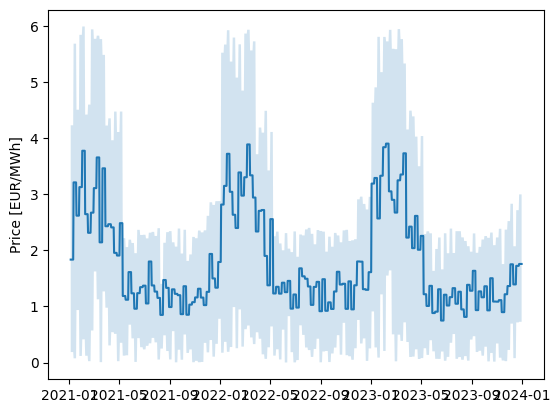

In [14]:
price = my_area.price.get()

f = plt.figure(0)
ax = plt.subplot(111)
ax.fill_between(price.index, np.percentile(price.values[:,:],0,axis=1),np.percentile(price.values[:,:],100,axis=1),alpha=0.2)
ax.plot(price.mean(axis=1))
ax.set(ylabel='Price [EUR/MWh]')
plt.show()

## Stochastic time series of production from ModuleA

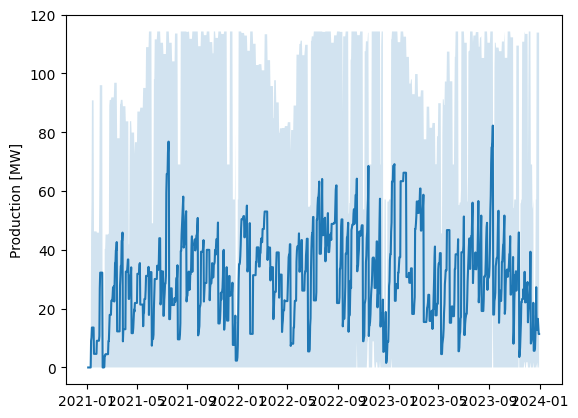

In [15]:
production = mod.production.get()

f = plt.figure(1)
ax = plt.subplot(111)
ax.fill_between(production.index, np.percentile(production.values[:,:],0,axis=1),np.percentile(production.values[:,:],100,axis=1),alpha=0.2)
ax.plot(production.mean(axis=1))
ax.set(ylabel='Production [MW]')
plt.show()